# Function approximation with linear models and neural network
### Dr. Tirthajyoti Sarkar, Fremont, CA ([LinkedIn](https://www.linkedin.com/in/tirthajyoti-sarkar-2127aa7/), [Github](https://tirthajyoti.github.io))

For more tutorial-style notebooks on deep learning, **[here is my Github repo](https://github.com/tirthajyoti/Deep-learning-with-Python)**.

For more tutorial-style notebooks on general machine learning, **[here is my Github repo](https://github.com/tirthajyoti/Machine-Learning-with-Python)**.

---

In this notebook, we show that linear model (even with high order polynomial terms) are not good enough to approximate highly nonlinear functions such a function containing transcedental function terms (such as $sin(x)$ or $exp(x)$).

We also show that, throwing a bunch of data to the model does not help as the model lacks the inherent 'capacity' to approximate nonlinearlity.

Next, we show how a relatively simple neural net with only a single hidden layer can fit the data quite well and in particular, how the performance of the neural net improves with larger dataset.

**NOTE**: We import utility functions of building Keras models and compiling/training them from the `utils` module. You need to clone this git and use those functions to run this notebook properly.

## Linear model
### Import basic libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Data generation variables for the 1-D linear model

In [2]:
N_points = 75 # Number of points for constructing function
x_min = 1 # Min of the range of x (feature)
x_max = 10 # Max of the range of x (feature)
noise_mean = 0 # Mean of the Gaussian noise adder
noise_sd = 2 # Std.Dev of the Gaussian noise adder

### Generate feature and output vector following a non-linear function

The ground truth or originating function is as follows:

$$ y=f(x)= (20x+3x^2+0.1x^3).sin(x).e^{-0.5x}+\psi(x) $$

where

$$\psi(x) : f(x\;|\;\mu ,\sigma ^{2})={\frac {1}{\sqrt {2\pi \sigma ^{2}}}}\;e^{-{\frac {(x-\mu )^{2}}{2\sigma ^{2}}}} $$

In [3]:
# Definition of the function with exponential and sinusoidal terms
def func_trans(x):
    result = (20*x+3*x**2+0.1*x**3)*np.sin(x)*np.exp(-0.5*x)
    return (result)

### Densely spaced points for generating the ideal functional curve

In [4]:
# Densely spaced points for generating the ideal functional curve
x_smooth = np.array(np.linspace(x_min,x_max,501))

# Use one of the following
y_smooth = func_trans(x_smooth)
#y_smooth = func_poly(x_smooth)

### Linearly spaced sample points, noise addition

In [5]:
# Linearly spaced sample points
X=np.array(np.linspace(x_min,x_max,N_points))

In [6]:
# Added observational/measurement noise
noise_x = np.random.normal(loc=noise_mean,scale=noise_sd,size=N_points)

In [7]:
# Observed output after adding the noise
y = func_trans(X)+noise_x

### Store the values in a DataFrame

In [8]:
# Store the values in a DataFrame
df = pd.DataFrame(data=X,columns=['X'])
df['Ideal y']=df['X'].apply(func_trans)
df['y']=y
df.head()

,X,Ideal y,y
0,1.000000,11.789731,15.071297
1,1.121622,13.546150,12.075853
2,1.243243,15.099926,13.649606
3,1.364865,16.394678,19.268800
4,1.486486,17.385284,17.057330


### Plot the function(s), both the ideal characteristic and the observed output (with process and observation noise)

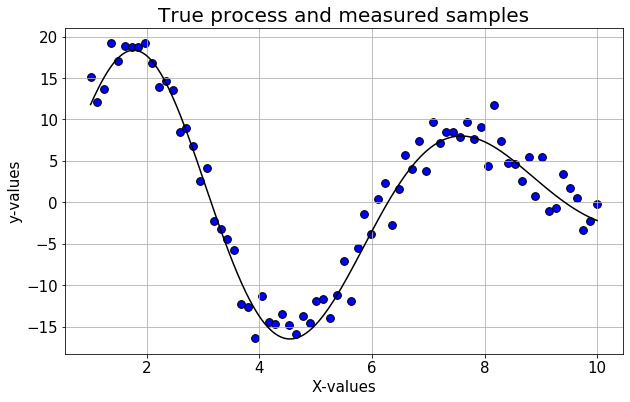

In [9]:
plt.figure(figsize=(10,6))
plt.title('True process and measured samples',fontsize=20)
plt.scatter(df['X'],df['y'],edgecolors=(0,0,0),c='blue',s=60)
plt.plot(x_smooth,y_smooth,'k')
plt.xlabel("X-values",fontsize=15)
plt.ylabel("y-values",fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(True)
plt.show()

### Import scikit-learn librares and prepare train/test splits

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import AdaBoostRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

In [11]:
X_train, X_test, y_train, y_test = train_test_split(df['X'], df['y'], test_size=0.33)

X_train=X_train.values.reshape(X_train.size,1)
y_train=y_train.values.reshape(y_train.size,1)
X_test=X_test.values.reshape(X_test.size,1)
y_test=y_test.values.reshape(y_test.size,1)

from sklearn import preprocessing
X_scaled = preprocessing.scale(X_train)
y_scaled = preprocessing.scale(y_train)

### Polynomial model with Ridge regularization (pipelined) with lineary spaced samples

We gradually increase the linear model complexity i.e. degree of highest polynomial term and see if the fit gets better. A regularized linear model (Ridge regression) with 5-fold cross-validation is used for this purpose.

We utilize the `PolynomialFeatures`,`make_pipeline` and `RidgeCV` methods from Scikit-learn.

### Regression model parameters

In [12]:
# Alpha (regularization strength) of ridge regression
ridge_alpha = tuple([10**(x) for x in range(-3,0,1) ])

# Min and max degree of polynomials features to consider
degree_min = 2
degree_max = 9

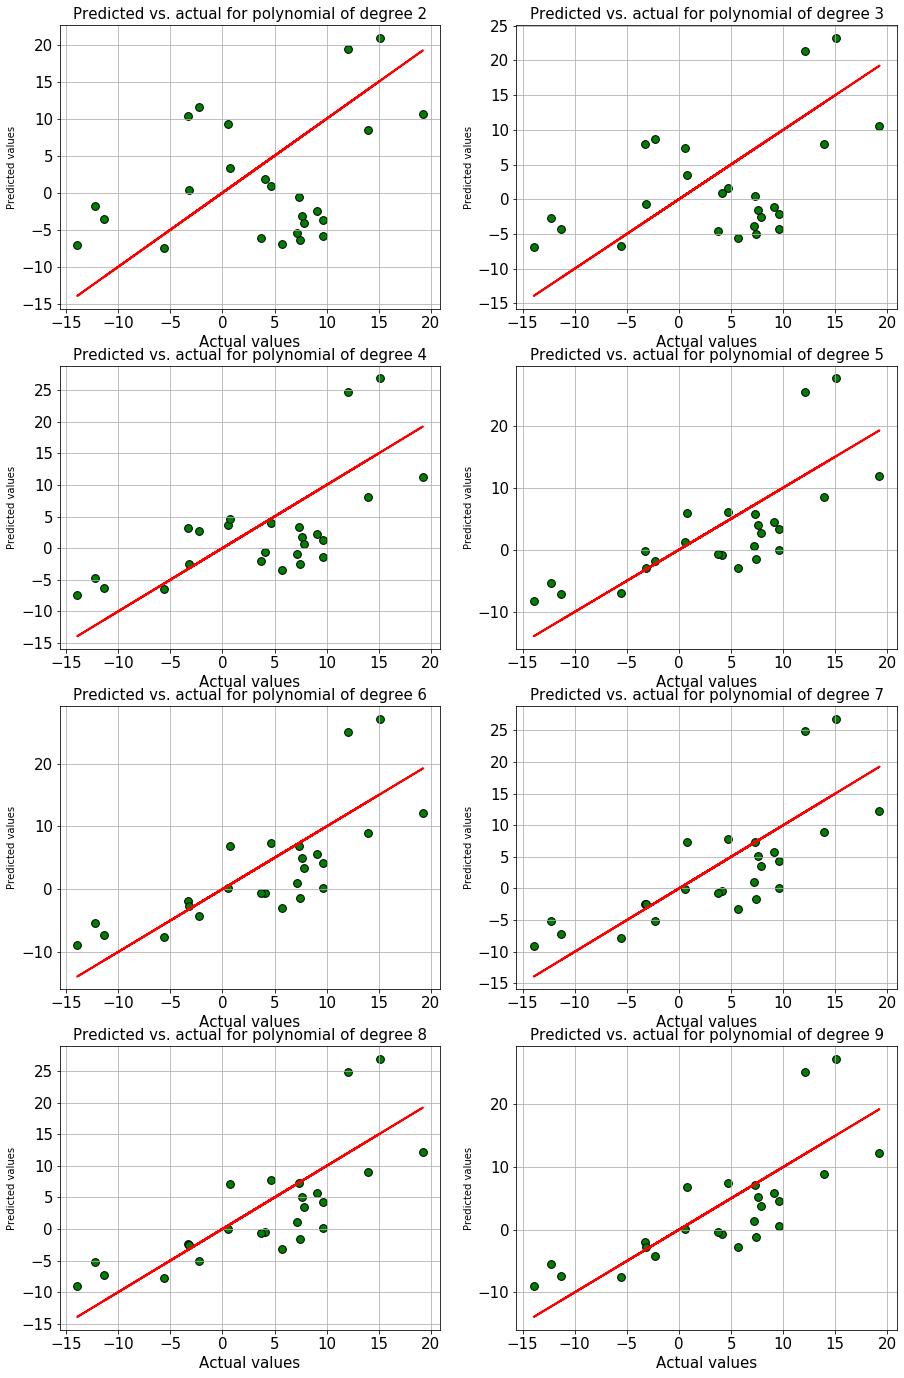

In [13]:
# Empty lists to store model data
linear_sample_score = []
poly_degree = []
rmse=[]
height = (int((degree_max-degree_min)/2)+1)*6
fig, ax = plt.subplots(nrows=int((degree_max-degree_min)/2)+1,ncols=2,figsize=(15,height))
ax = ax.ravel()
# Iterate over increasing degree of polynomial complexity
for i,degree in enumerate(range(degree_min,degree_max+1)):
    model = make_pipeline(PolynomialFeatures(degree), RidgeCV(alphas=ridge_alpha,normalize=True,cv=5))
    #model = make_pipeline(PolynomialFeatures(degree), LassoCV(eps=lasso_eps,n_alphas=lasso_nalpha, 
    #                                                              max_iter=lasso_iter,normalize=True,cv=5))
    #model = make_pipeline(PolynomialFeatures(degree), LinearRegression(normalize=True))
    model.fit(X_train, y_train)
    
    y_pred = np.array(model.predict(X_train))
    test_pred = np.array(model.predict(X_test))
    # RMSE
    RMSE=np.sqrt(np.sum(np.square(test_pred-y_test)))
    # R^2 score
    test_score = model.score(X_test,y_test)
    
    linear_sample_score.append(test_score)
    rmse.append(RMSE)
    poly_degree.append(degree)
       
    ax[i].set_title("Predicted vs. actual for polynomial of degree {}".format(degree),fontsize=15)
    ax[i].set_xlabel("Actual values",fontsize=15)
    ax[i].set_ylabel("Predicted values")
    ax[i].scatter(y_test,test_pred,edgecolor='k',color='green',s=60)
    ax[i].grid(True)
    ax[i].plot(y_test,y_test,'r',lw=2)
    ax[i].tick_params(axis='both', which='major', labelsize=15)
plt.show()

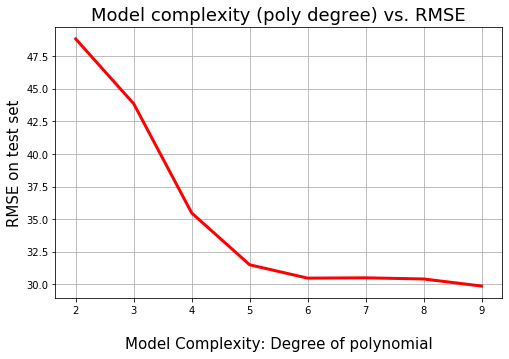

In [14]:
plt.figure(figsize=(8,5))
plt.title("Model complexity (poly degree) vs. RMSE",fontsize=18)
plt.grid(True)
plt.plot(poly_degree,rmse,lw=3,c='red')
plt.xlabel ("\nModel Complexity: Degree of polynomial",fontsize=15)
plt.ylabel ("RMSE on test set",fontsize=15)
plt.show()

In [15]:
df_score = pd.DataFrame(data={'degree':[d for d in range(degree_min,degree_max+1)],
                              'Linear sample score':linear_sample_score})

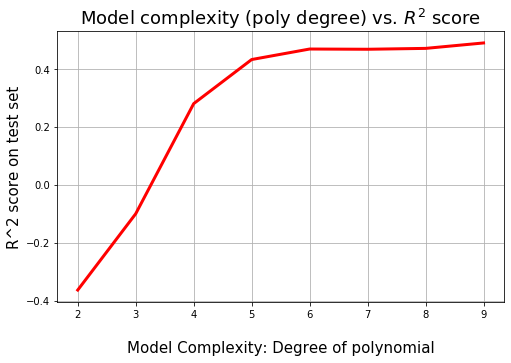

In [16]:
plt.figure(figsize=(8,5))
plt.title("Model complexity (poly degree) vs. $R^2$ score",fontsize=18)
plt.grid(True)
plt.plot(poly_degree,linear_sample_score,lw=3,c='red')
plt.xlabel ("\nModel Complexity: Degree of polynomial",fontsize=15)
plt.ylabel ("R^2 score on test set",fontsize=15)
plt.show()

### Will more data points help?

In [17]:
N_points = 750 # Number of points for constructing function
x_min = 1 # Min of the range of x (feature)
x_max = 10 # Max of the range of x (feature)
noise_mean = 0 # Mean of the Gaussian noise adder
noise_sd = 2 # Std.Dev of the Gaussian noise adder

X=np.array(np.linspace(x_min,x_max,N_points))
noise_x = np.random.normal(loc=noise_mean,scale=noise_sd,size=N_points)
y = func_trans(X)+noise_x

df = pd.DataFrame(data=X,columns=['X'])
df['Ideal y']=df['X'].apply(func_trans)
df['y']=y

X_train, X_test, y_train, y_test = train_test_split(df['X'], df['y'], test_size=0.33)

X_train=X_train.values.reshape(X_train.size,1)
y_train=y_train.values.reshape(y_train.size,1)
X_test=X_test.values.reshape(X_test.size,1)
y_test=y_test.values.reshape(y_test.size,1)

from sklearn import preprocessing
X_scaled = preprocessing.scale(X_train)
y_scaled = preprocessing.scale(y_train)

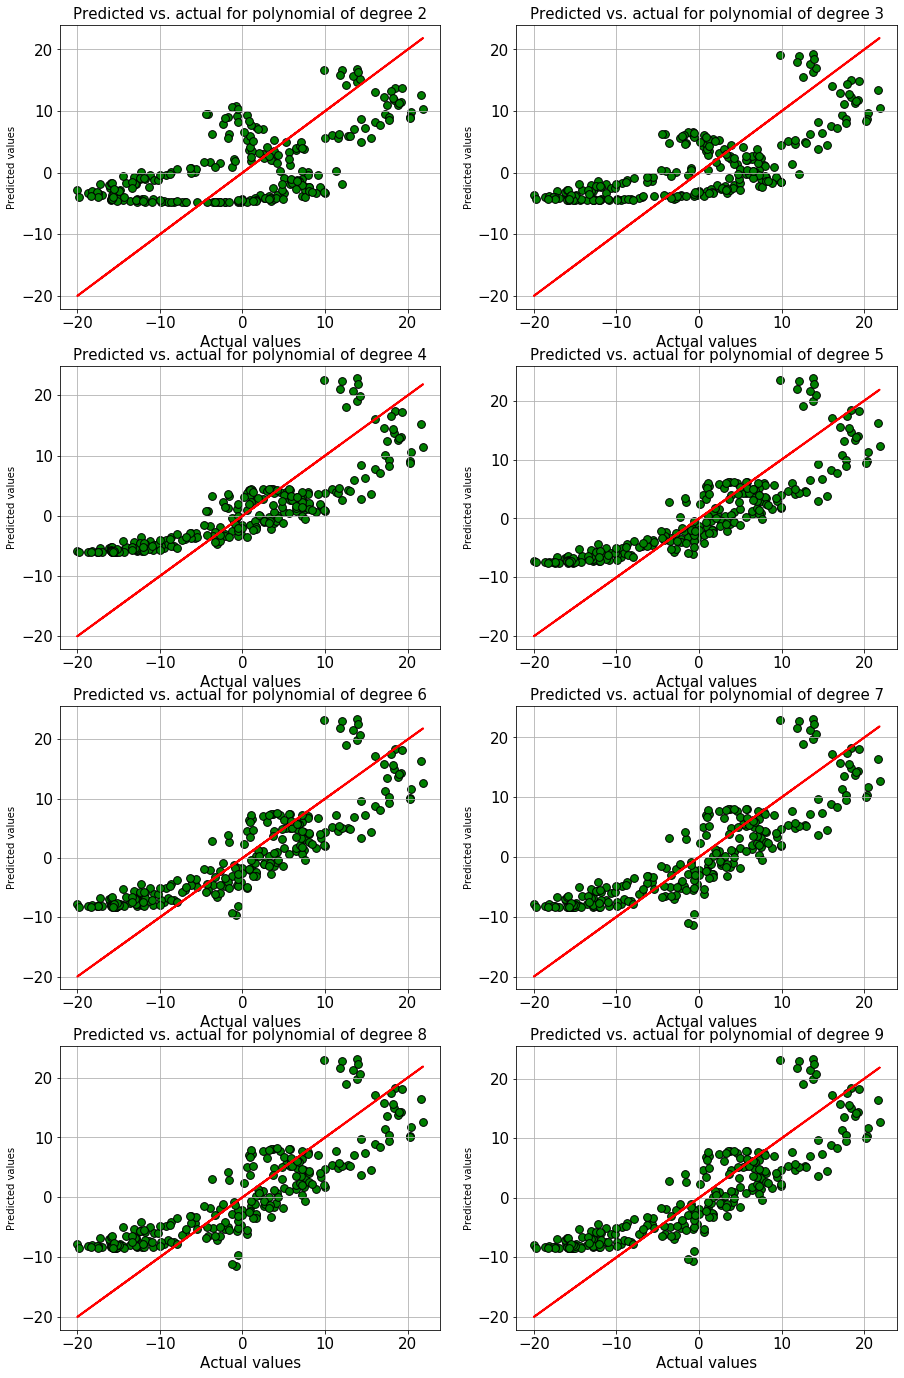

In [18]:
# Empty lists to store model data
linear_sample_score = []
poly_degree = []
rmse=[]
height = (int((degree_max-degree_min)/2)+1)*6
fig, ax = plt.subplots(nrows=int((degree_max-degree_min)/2)+1,ncols=2,figsize=(15,height))
ax = ax.ravel()
# Iterate over increasing degree of polynomial complexity
for i,degree in enumerate(range(degree_min,degree_max+1)):
    model = make_pipeline(PolynomialFeatures(degree), RidgeCV(alphas=ridge_alpha,normalize=True,cv=5))
    #model = make_pipeline(PolynomialFeatures(degree), LassoCV(eps=lasso_eps,n_alphas=lasso_nalpha, 
    #                                                              max_iter=lasso_iter,normalize=True,cv=5))
    #model = make_pipeline(PolynomialFeatures(degree), LinearRegression(normalize=True))
    model.fit(X_train, y_train)
    
    y_pred = np.array(model.predict(X_train))
    test_pred = np.array(model.predict(X_test))
    # RMSE
    RMSE=np.sqrt(np.sum(np.square(test_pred-y_test)))
    # R^2 score
    test_score = model.score(X_test,y_test)
    
    linear_sample_score.append(test_score)
    rmse.append(RMSE)
    poly_degree.append(degree)
       
    ax[i].set_title("Predicted vs. actual for polynomial of degree {}".format(degree),fontsize=15)
    ax[i].set_xlabel("Actual values",fontsize=15)
    ax[i].set_ylabel("Predicted values")
    ax[i].scatter(y_test,test_pred,edgecolor='k',color='green',s=60)
    ax[i].grid(True)
    ax[i].plot(y_test,y_test,'r',lw=2)
    ax[i].tick_params(axis='both', which='major', labelsize=15)
plt.show()

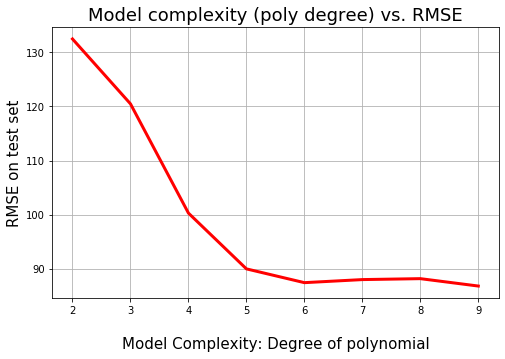

In [19]:
plt.figure(figsize=(8,5))
plt.title("Model complexity (poly degree) vs. RMSE",fontsize=18)
plt.grid(True)
plt.plot(poly_degree,rmse,lw=3,c='red')
plt.xlabel ("\nModel Complexity: Degree of polynomial",fontsize=15)
plt.ylabel ("RMSE on test set",fontsize=15)
plt.show()

### Summary of linear model

No linear model (even with higher degree of polynomials) could fit the data well. In fact, after around 6th degree polynomial, the $R^2$ stops improving altogether and the RMSE loss flattens out.

And most importantly, **ten times data did not help the matter at all**. This is because the model **does not have the capacity and flexibility of a truly nonlinear model like neural net**.

---

## Neural network for regression

### Importing functions

We import utility functions of building Keras models and compiling/training them from the `utils` module. You need to clone this git and use those functions to run this notebook properly.

In [20]:
import tensorflow as tf
from utils.DL_utils import *

### Recreate the data (small dataset of 75 points)

In [21]:
N_points = 75 # Number of points for constructing function
x_min = 1 # Min of the range of x (feature)
x_max = 10 # Max of the range of x (feature)
noise_mean = 0 # Mean of the Gaussian noise adder
noise_sd = 2 # Std.Dev of the Gaussian noise adder

X=np.array(np.linspace(x_min,x_max,N_points))
noise_x = np.random.normal(loc=noise_mean,scale=noise_sd,size=N_points)
y = func_trans(X)+noise_x

df = pd.DataFrame(data=X,columns=['X'])
df['Ideal y']=df['X'].apply(func_trans)
df['y']=y

X_train, X_test, y_train, y_test = train_test_split(df['X'], df['y'], test_size=0.33)

X_train=X_train.values.reshape(X_train.size,1)
y_train=y_train.values.reshape(y_train.size,1)
X_test=X_test.values.reshape(X_test.size,1)
y_test=y_test.values.reshape(y_test.size,1)

### Scaling the data

In [22]:
from sklearn.preprocessing import StandardScaler

In [23]:
scalerx = StandardScaler()
scalery = StandardScaler()

In [24]:
X_train_scaled = scalerx.fit_transform(X_train)
y_train_scaled = scalery.fit_transform(y_train)
X_test_scaled = scalerx.fit_transform(X_test)
y_test_scaled = scalery.fit_transform(y_test)

### Neural network parameters

In [25]:
architecture = [32]
input_neurons=32
num_layers=1
activation = 'relu'
input_dim=1

In [26]:
nn_model = build_regression_model(input_neurons=input_neurons,num_layers=num_layers,
                                  architecture=architecture,input_dim=input_dim,
                                  act_func=activation)

Instructions for updating:
Colocations handled automatically by placer.


In [27]:
nn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                64        
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,153
Trainable params: 1,153
Non-trainable params: 0
_________________________________________________________________


So, this model has 1153 parameters.

### Compile and train model
Note that because we have so little data, we set the batch size to 1 for this training.

In [28]:
trained_model=compile_train_regression_model(nn_model,X_train_scaled,y_train_scaled,batch_size=1,verbose=0,epochs=100)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.


### Plot the loss over epochs

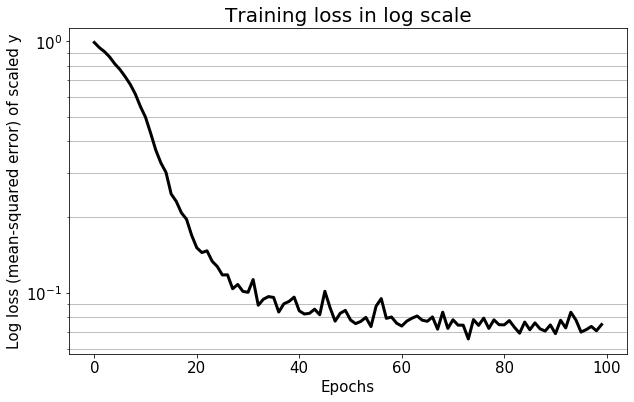

In [29]:
plt.figure(figsize=(10,6))
plt.title("Training loss in log scale",fontsize=20)
plt.semilogy(trained_model.history.history['loss'],color='k',lw=3)
plt.grid(True,which='minor')
plt.xlabel("Epochs",fontsize=15)
plt.ylabel("Log loss (mean-squared error) of scaled y",fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

### Predictions

In [30]:
yhat=scalery.inverse_transform(trained_model.predict(X_test_scaled))

### Plot the fitted vs. predicted

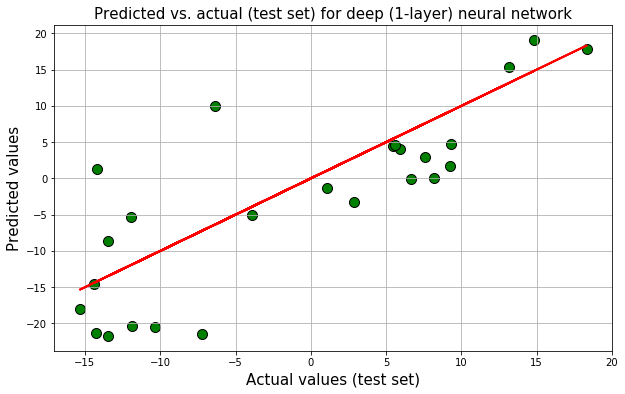

In [31]:
plt.figure(figsize=(10,6))
plt.title("Predicted vs. actual (test set) for deep (1-layer) neural network",fontsize=15)
plt.xlabel("Actual values (test set)",fontsize=15)
plt.ylabel("Predicted values",fontsize=15)
plt.scatter(y_test,yhat,edgecolors='k',s=100,c='green')
plt.grid(True)
plt.plot(y_test,y_test,'r',lw=2)
plt.show()

### Plot residuals vs. fitted

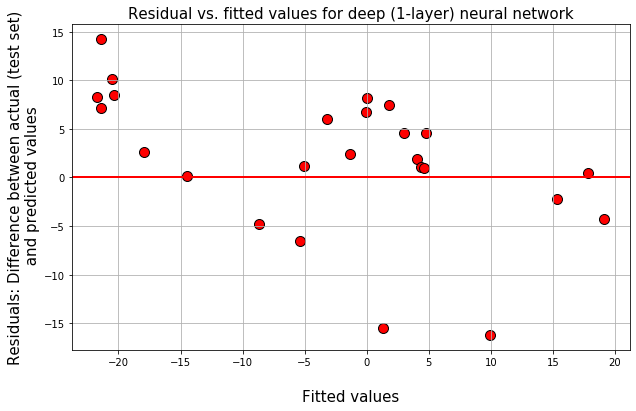

In [32]:
plt.figure(figsize=(10,6))
plt.scatter(yhat,y_test-yhat,edgecolors='k',s=100,c='red')
plt.title("Residual vs. fitted values for deep (1-layer) neural network",fontsize=15)
plt.xlabel("\nFitted values",fontsize=15)
plt.ylabel("Residuals: Difference between actual (test set)\n and predicted values",fontsize=15)
plt.grid(True)
plt.axhline(y=0,lw=2,c='red')
plt.show()

### Big Data! Need more samples for NN
Obviously, the fitting was somewhat better with the neural net than the linear model but to take real advantage of a model with high parameter count like deep neural net, we need more data.

We still keep only a single hidden layer.

In [33]:
N_points = 750 # Number of points for constructing function
x_min = 1 # Min of the range of x (feature)
x_max = 10 # Max of the range of x (feature)
noise_mean = 0 # Mean of the Gaussian noise adder
noise_sd = 2 # Std.Dev of the Gaussian noise adder

X=np.array(np.linspace(x_min,x_max,N_points))
noise_x = np.random.normal(loc=noise_mean,scale=noise_sd,size=N_points)
y = func_trans(X)+noise_x

df = pd.DataFrame(data=X,columns=['X'])
df['Ideal y']=df['X'].apply(func_trans)
df['y']=y

X_train, X_test, y_train, y_test = train_test_split(df['X'], df['y'], test_size=0.33)

X_train=X_train.values.reshape(X_train.size,1)
y_train=y_train.values.reshape(y_train.size,1)
X_test=X_test.values.reshape(X_test.size,1)
y_test=y_test.values.reshape(y_test.size,1)

scalerx = StandardScaler()
scalery = StandardScaler()

X_train_scaled = scalerx.fit_transform(X_train)
y_train_scaled = scalery.fit_transform(y_train)
X_test_scaled = scalerx.fit_transform(X_test)
y_test_scaled = scalery.fit_transform(y_test)

In [34]:
architecture = [32]
input_neurons=32
num_layers=1
activation = 'relu'
input_dim=1

In [35]:
nn_model = build_regression_model(input_neurons=input_neurons,num_layers=num_layers,
                                  architecture=architecture,input_dim=input_dim,
                                  act_func=activation)

In [36]:
nn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 32)                64        
_________________________________________________________________
dense_4 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 1,153
Trainable params: 1,153
Non-trainable params: 0
_________________________________________________________________


### We can increase the batch size with more data

In [37]:
trained_model=compile_train_regression_model(nn_model,X_train_scaled,y_train_scaled,batch_size=4,verbose=0,epochs=100)

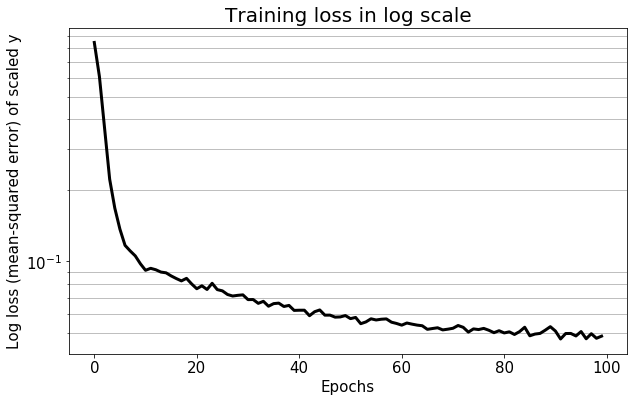

In [38]:
plt.figure(figsize=(10,6))
plt.title("Training loss in log scale",fontsize=20)
plt.semilogy(trained_model.history.history['loss'],color='k',lw=3)
plt.grid(True,which='minor')
plt.xlabel("Epochs",fontsize=15)
plt.ylabel("Log loss (mean-squared error) of scaled y",fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [39]:
yhat=scalery.inverse_transform(trained_model.predict(X_test_scaled))

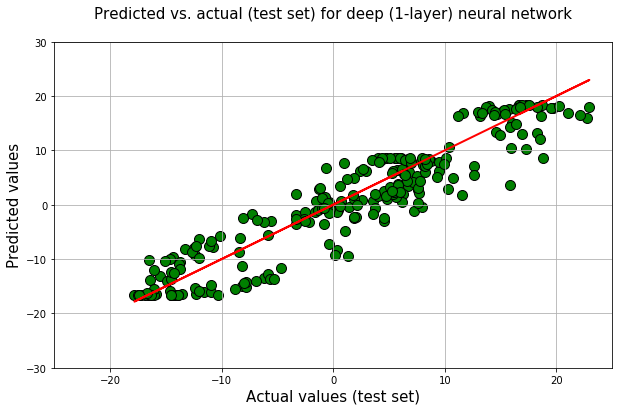

In [40]:
plt.figure(figsize=(10,6))
plt.title("Predicted vs. actual (test set) for deep (1-layer) neural network\n",fontsize=15)
plt.xlabel("Actual values (test set)",fontsize=15)
plt.ylabel("Predicted values",fontsize=15)
plt.scatter(y_test,yhat,edgecolors='k',s=100,c='green')
plt.xlim(-25,25)
plt.ylim(-30,30)
plt.grid(True)
plt.plot(y_test,y_test,'r',lw=2)
plt.show()

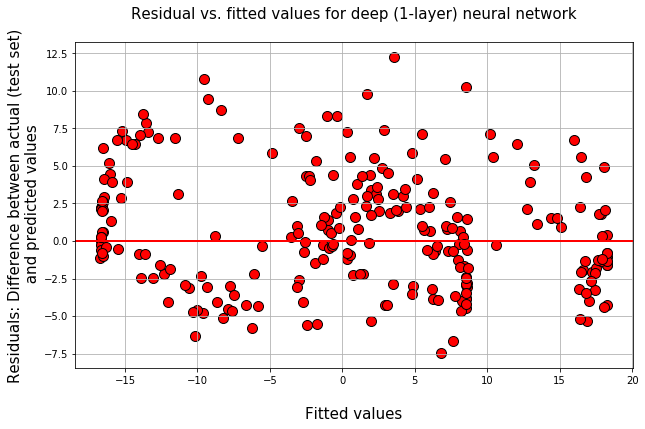

In [41]:
plt.figure(figsize=(10,6))
plt.scatter(yhat,y_test-yhat,edgecolors='k',s=100,c='red')
plt.title("Residual vs. fitted values for deep (1-layer) neural network\n",fontsize=15)
plt.xlabel("\nFitted values",fontsize=15)
plt.ylabel("Residuals: Difference between actual (test set)\n and predicted values",fontsize=15)
plt.grid(True)
plt.axhline(y=0,lw=2,c='red')
plt.show()

### Two hidden layers and more epochs of training

In [42]:
architecture = [32,32]
input_neurons=32
num_layers=2
activation = 'relu'
input_dim=1

In [43]:
nn_model = build_regression_model(input_neurons=input_neurons,num_layers=num_layers,
                                  architecture=architecture,input_dim=input_dim,
                                  act_func=activation)

In [44]:
nn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 32)                64        
_________________________________________________________________
dense_7 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_8 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 33        
Total params: 2,209
Trainable params: 2,209
Non-trainable params: 0
_________________________________________________________________


In [45]:
trained_model=compile_train_regression_model(nn_model,X_train_scaled,y_train_scaled,batch_size=4,verbose=0,epochs=200)

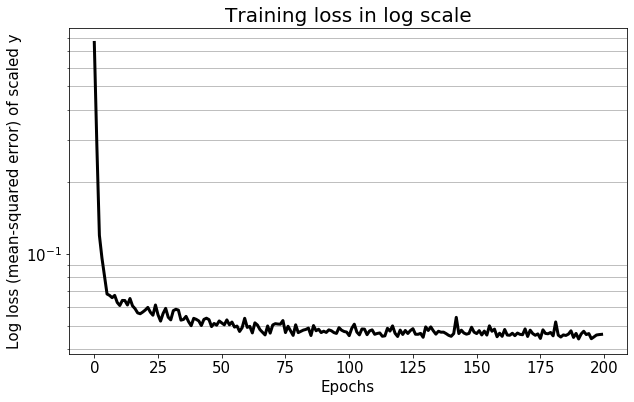

In [46]:
plt.figure(figsize=(10,6))
plt.title("Training loss in log scale",fontsize=20)
plt.semilogy(trained_model.history.history['loss'],color='k',lw=3)
plt.grid(True,which='minor')
plt.xlabel("Epochs",fontsize=15)
plt.ylabel("Log loss (mean-squared error) of scaled y",fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [47]:
yhat=scalery.inverse_transform(trained_model.predict(X_test_scaled))

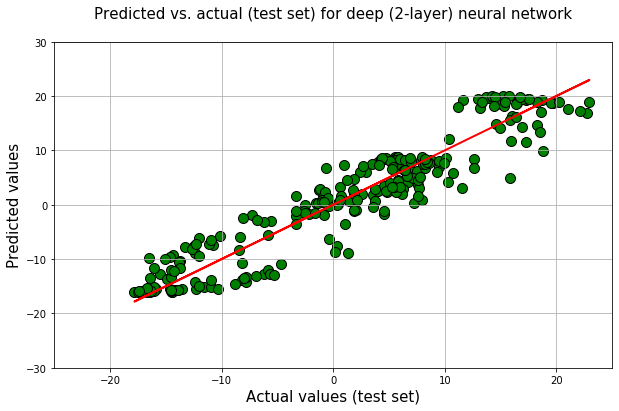

In [48]:
plt.figure(figsize=(10,6))
plt.title("Predicted vs. actual (test set) for deep (2-layer) neural network\n",fontsize=15)
plt.xlabel("Actual values (test set)",fontsize=15)
plt.ylabel("Predicted values",fontsize=15)
plt.scatter(y_test,yhat,edgecolors='k',s=100,c='green')
plt.xlim(-25,25)
plt.ylim(-30,30)
plt.grid(True)
plt.plot(y_test,y_test,'r',lw=2)
plt.show()

### Summary

So, we did not observe much improvement in performance with more hidden layers, although it is clear that more data points helped the neural network to fit the nonlinar dataset quite better than what linear model could do.